# Detecting Mental Clues Remotely

## Using machine learning models to predict mental changes and conducting SHAP analysis for explainable machine learning

## Figure 6

In [2]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0, sys.path[0]+"/../")
from mmer.constant_variable import *
from mmer.ml import parameter_optimization as op
from mmer.ml import dataset as dt
from mmer.ml import supervised_learning as svl


In [4]:
# 需要決定的參數
step = [11, 21]  # 只想比较步骤11和21的二分类预测结果
method_list = ["rf", "svm"]  # 比较rf和svm的分类结果
mode = "rPPG"  # 使用的数据是rPPG

target_folder_path = './results/remote_ppg/'


In [ ]:
result = {"total_accuracy": [], "total_F1": []}

for method in method_list:
    input_file_path = os.path.join(target_folder_path, "bpm_output","summary","result_updated.csv")
    output_file_path = os.path.join(target_folder_path, "bpm_output","summary", "{}_{}_{}_results.csv".format(mode, method, "vs".join(list(map(str, step)))))

    param_dict = {
        "input_file_path": input_file_path,
        "output_file_path": output_file_path,
        # "save_path_bar": save_path_bar,
        # "save_path_dot": save_path_dot,
        "model": method,
        "features": hrv_variable_list,
        # "add_principal_component_analysis": False,
        # "n_principal_component_list": [int(x) for x in np.linspace(3, 15, num=13)],
        "parameter_grid_search": False,
        "select_important_feature": False,
        "n_parameter_grid_search_iteration": 100,
        "repeat_times": 1,
        "parameter_search_fold": 5,
        "n_fold": 10,
    }

    # 读取并标准化数据，初始化模型
    x_read, y_read, remember_no = dt.Dataset().read_dataset(param_dict["features"], input_file_path, step=step)
    model_random = op.AutoOptimize().model_preparation(method)
    scaler = StandardScaler()

    x_read_scaled = scaler.fit_transform(x_read)
    x_read_scaled = pd.DataFrame(data=x_read_scaled)


    # 初始化交叉验证和模型参数
    cross_validation_settings = cv.cross_validation_setting_model(n_fold = 10,
                                                                  repeat_times = 1,
                                                                  add_principal_component_analysis = False,  # 为false表示不做主成分分析
                                                                  principal_component_ratio = 0.85)  # 根据 累计解释方差比率 决定主成分个数，此处阈值设定为0.85

    data_model_settings = svl.supervised_learning_data_model(x = x_read_scaled,
                                                             Y = y_read,
                                                             remember_no = remember_no)

    
    # 模型训练
    acc, f1 = cv.cross_validation(param_dict).do_cross_validation(cross_validation_settings, data_model_settings, model_random)

    result["total_accuracy"].append(acc)
    result["total_F1"].append(f1)



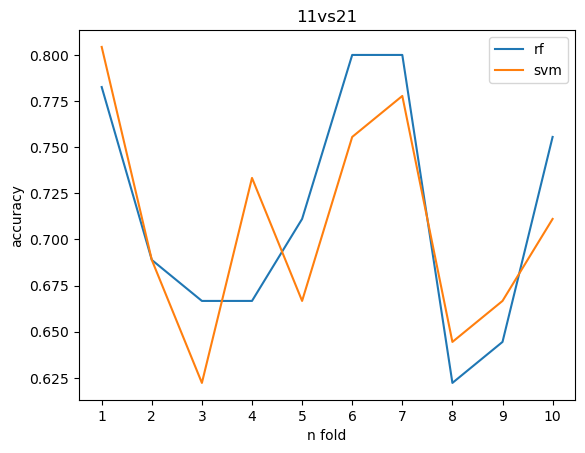

In [10]:
import matplotlib.pyplot as plt

x = [i for i in range(1, len(result["total_accuracy"][0])+1)]

for ind, method in enumerate(method_list):
    plt.plot(x, result["total_accuracy"][ind], label = method)

plt.xticks(x)
plt.legend(method_list)
plt.xlabel("n fold")
plt.ylabel("accuracy")
plt.title("vs".join(list(map(str, step))))
plt.show()

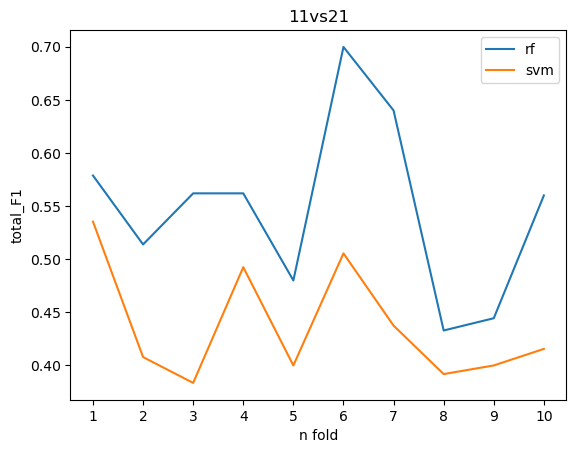

In [11]:
import matplotlib.pyplot as plt

x = [i for i in range(1, len(result["total_F1"][0])+1)]

for ind, method in enumerate(method_list):
    plt.plot(x, result["total_F1"][ind], label = method)

plt.xticks(x)
plt.legend(method_list)
plt.xlabel("n fold")
plt.ylabel("total_F1")
plt.title("vs".join(list(map(str, step))))
plt.show()